In [12]:
import pandas as pd
from pandasai.llm.openai import OpenAI
from pandasai import SmartDataframe
from dotenv import load_dotenv
from langchain_experimental.agents import create_pandas_dataframe_agent
from langchain.chat_models import ChatOpenAI
import matplotlib.pyplot as plt
import seaborn as sns

In [17]:
# Load environment variables from .env (ensure you have OpenAI keys set here)
load_dotenv()

# Load your CSV data into a pandas DataFrame
df = pd.read_csv("basededados_aulat7.csv")

# Initialize OpenAI LLM for PandasAI
llm = OpenAI(temperature=0)

# Use PandasAI's SmartDataframe for natural language queries on the dataframe
sdf = SmartDataframe(df, config={"llm": llm})

# Initialize LangChain's OpenAI model for broader language tasks
chat_openai = ChatOpenAI(temperature=0)

# Create a LangChain agent for Pandas DataFrame using the loaded DataFrame and LLM
agent = create_pandas_dataframe_agent(chat_openai, df, verbose=True, allow_dangerous_code=True)



In [18]:
# Combined function to process the question and return filtered data, plot, and insights
def process_question(question: str):
    # Step 1: Filter DataFrame using SmartDataframe based on question
    print("Filtering data based on question...")
    filtered_df = sdf.chat(question)
    
    # Step 2: Analyze the filtered DataFrame and choose the best chart type
    chart_type = choose_best_chart(filtered_df)
    
    # Step 3: Plot the best chart based on analysis
    if not filtered_df.empty:
        plot_best_chart(filtered_df, chart_type)
    
    # Step 4: Provide insights based on the question and data
    print("Providing insights...")
    insights = provide_insights(question)
    
    return filtered_df, insights

# Function to choose the best chart based on the types of columns
def choose_best_chart(df: pd.DataFrame):
    if df.shape[0] == 1:
        # If there's only one row, return text response (no chart)
        return "text"
    
    # Check the data types of columns
    numerical_cols = df.select_dtypes(include=['number']).columns
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns
    
    if len(numerical_cols) == 2:
        return "scatter"  # 2 numerical columns -> scatter plot
    elif len(categorical_cols) >= 1 and len(numerical_cols) >= 1:
        return "bar"  # 1 categorical and 1 numerical -> bar chart
    else:
        return "text"  # Default to text if no clear chart type is identified

# Function to plot the best chart based on the selected chart type
def plot_best_chart(df: pd.DataFrame, chart_type: str):
    if chart_type == "bar":
        # Assuming we want to plot a bar chart with the first categorical and numerical columns
        categorical_col = df.select_dtypes(include=['object', 'category']).columns[0]
        numerical_col = df.select_dtypes(include=['number']).columns[0]
        sns.barplot(data=df, x=categorical_col, y=numerical_col)
        plt.title(f"Bar Chart: {categorical_col} vs {numerical_col}")
        plt.show()
    
    elif chart_type == "scatter":
        # Assuming we want to plot a scatter plot with two numerical columns
        numerical_cols = df.select_dtypes(include=['number']).columns
        sns.scatterplot(data=df, x=numerical_cols[0], y=numerical_cols[1])
        plt.title(f"Scatter Plot: {numerical_cols[0]} vs {numerical_cols[1]}")
        plt.show()
    
    elif chart_type == "text":
        print("Only one row of data, no chart to display.")

# Function to provide insights from the DataFrame based on a natural language query
def provide_insights(query: str):
    response = agent.run(query)
    return response

Filtering data based on question...
{'type': 'dataframe', 'value':                                      produto  qtd  total_value
0    ABS ADT GERIAMAX 20UND POS PARTO INCONT    4        12.64
1             ABS ALWAYS BAS 16UND SEC C/ABA   42        85.14
2              ABS ALWAYS BAS 16UND SV C/ABA   29        58.32
3           ABS ALWAYS BAS 18X8UND SEC C/ABA    2        13.69
4           ABS ALWAYS BAS 18X8UND SEC S/ABA    7        46.30
..                                       ...  ...          ...
757        UMIDILIZ UMIDIF MURIEL 250ML COCO    6        16.38
758  UMIDILIZ UMIDIF MURIEL 250ML FORM CACHO    4        10.92
759        UMIDILIZ UMIDIF MURIEL 250ML TEEN   10        27.34
760                    VS CONDOR MADRI C/CAB    6        18.18
761                 VS CONDOR PELO C/CAB V-9    4        15.52

[762 rows x 3 columns]}
{'type': 'plot', 'value': 'c:/Users/PedroLustosa/langchain_csv_dataviz/exports/charts/temp_chart.png'}


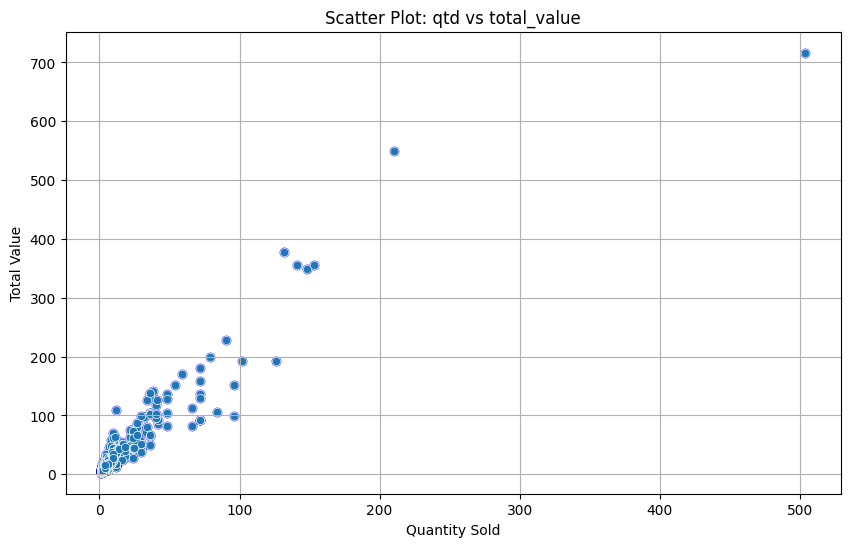

Providing insights...
Thought: To understand how quantity relates to value, we can calculate the total value for each row by multiplying the quantity by the unit value.

Action: python_repl_ast
Action Input: df['total_value'] = df['qtd'] * df['vlrunitario']Now we have a new column in the dataframe called 'total_value' which represents the total value for each row.

Question: Qual a relação entre a quantidade e o valor total?
Thought: To analyze the relationship between quantity and total value, we can calculate the correlation between these two columns.

Action: python_repl_ast
Action Input: df['qtd'].corr(df['total_value'])0.9242143187512529A correlação entre a quantidade e o valor total é de aproximadamente 0.92.

Final Answer: A relação entre a quantidade e o valor total é de aproximadamente 0.92.

> Finished chain.
Filtered Data:
                                     produto  qtd  total_value
0    ABS ADT GERIAMAX 20UND POS PARTO INCONT    4        12.64
1             ABS ALWAYS BAS

In [21]:
# Example usage: Input a natural language question
question = "Como a quantidade se relaciona com valor?"

# Process the question to get filtered data, plot, and insights
filtered_data, insights = process_question(question)

# Display filtered data and insights
print("Filtered Data:")
print(filtered_data)

print("\nInsights:")
print(insights)

In [22]:
filtered_data

,produto,qtd,total_value
0,ABS ADT GERIAMAX 20UND POS PARTO INCONT,4,12.64
1,ABS ALWAYS BAS 16UND SEC C/ABA,42,85.14
2,ABS ALWAYS BAS 16UND SV C/ABA,29,58.32
3,ABS ALWAYS BAS 18X8UND SEC C/ABA,2,13.69
4,ABS ALWAYS BAS 18X8UND SEC S/ABA,7,46.30
...,...,...,...
757,UMIDILIZ UMIDIF MURIEL 250ML COCO,6,16.38
758,UMIDILIZ UMIDIF MURIEL 250ML FORM CACHO,4,10.92
759,UMIDILIZ UMIDIF MURIEL 250ML TEEN,10,27.34
760,VS CONDOR MADRI C/CAB,6,18.18
